## Extraktion der Daten:
- basierend auf example.py werden hier Daten extrahier

Imports:

In [1]:
import json
from tqdm import tqdm
import time

from utils import *

### Finden von Occurences

Aus stop_times.txt werden für jeden Stop aus stops.txt Zeilen extrahiert, in denen der stop vorkommt:

In [2]:
def all_occ_numbers():
    print("finding occurencies")
    stop_times = load_stop_times()
    line_numbers = {k: [] for k in [i[0] for i in load_stops()]}
    c = time.perf_counter()
    new_list = []
    for ind, elem in enumerate(stop_times):
        new_list.append((elem[3], ind))
    #new_list = sorted(new_list, key=lambda x: x[0])
    for elem in new_list:
        line_numbers[elem[0]].append(elem[1])
    with open("lvb_auswertung/occ_numbers.json", "w+") as f:
        json.dump(line_numbers, f, indent=4)
    print("found occurencies")

def load_all_occ_numbers():
    with open("lvb_auswertung/occ_numbers.json", "r") as f:
        data = json.load(f)
    return data



### Finden von Nachbarn mit minimaler Transferzeit

Nun finden wir für jede Occurency und jede Station heraus, welche Nachbarn und welche minimale Transferzeit sie zu einem Nachbarn hat.

Zunächst benötigen wir dazu zwei Hilfsfunktionen:


In [3]:
def time_sec(time):
    time = time.replace('"', '')
    return 3600*int(time[0:2])+60*int(time[3:5])+int(time[6:8])

def find_neighbours(stop_times, occ_numbers):
    neighbours = []
    neighbour_times = []
    for occ_number in occ_numbers:
        point = stop_times[occ_number]
        point_arr = time_sec(stop_times[occ_number][1])
        point_dep = time_sec(stop_times[occ_number][2])
        if occ_number != 0:
            before = stop_times[occ_number-1]
            diff = point_arr-time_sec(stop_times[occ_number-1][2])
            if before[0] == point[0]:
                neighbour_times.append((before[3], diff))
                neighbours.append(before[3])
        
        if occ_number != len(stop_times)-1:
            after = stop_times[occ_number+1]
            diff = time_sec(stop_times[occ_number+1][1])-point_dep
            if after[0] == point[0]:
                neighbour_times.append((after[3], diff))
                neighbours.append(after[3])
    neighbours = list(set(neighbours))
    def min_time(neighbour):
        min_list = [elem[1] for elem in neighbour_times if elem[0] == neighbour]
        min_list = [elem for elem in min_list if elem != 0]
        if len(min_list) == 0:
            return 0
        return min(min_list)
    return [(
                neighbour, min_time(neighbour)
            ) for neighbour in neighbours]

Erklärung der Funktionen:

- time_sec:
  - Eine Zeit im Format "hh:mm:ss" wird in Sekunden umgerechnet
  - Die Differenzen können einfach zwischen der arrival und departure-Zeit errechnet werden, findet eine Fahrt um Mitternacht statt, gibt es Uhrzeiten mit Stunde 24 und 25, daher kann diese Funktion für Differenzen verwendet werden.

- find_neighbours: ermittelt für einen Stop alle Nachbarn mit minimaler Transferzeit
  - Die Liste mit allen stop_times und occurency_numbers für einen Stop wird übergeben
  - für jede occurency eines Stops wird ermittelt, welcher Stop davor und danach (before und after) angefahren wird (index davor bzw. danach falls vorhanden, gleicher Trip)
  - zu einer Liste wird der Nachbar hinzugefügt, zu einer anderen der Nachbar und eine Zeitdifferenz
  - zuletzt wird für jeden Nachbar die minimale Transferzeit größer als 0 extrahiert

Ermittlung aller Nachbarn

Anschließend wird die find_neighbours-Funktion für jeden Stop aus stops.txt ausgeführt, die gefundenen Nachbarn und Zeiten werden gespeichert.

In [4]:
def all_neighbours():
    print("loading data...")
    stop_ids = [i[0] for i in load_stops()]
    stop_times = load_stop_times()
    occ_numbers = load_all_occ_numbers()
    all_neighbours = {}
    print("finding neighbours...")
    #for elem in stop_ids[:1]:
    for elem in tqdm(stop_ids):
        all_neighbours[elem] = find_neighbours(stop_times, occ_numbers[elem])
    with open("lvb_auswertung/neighbours.json", "w+") as f:
        json.dump(all_neighbours, f, indent=4)
    print("finished...")




### Run the extractor

In [5]:
all_occ_numbers()
all_neighbours()

finding occurencies


FileNotFoundError: [Errno 2] No such file or directory: 'gtfsmdvlvb/stop_times.txt'

In [ ]:
import json
def load_all_neighbours():
    with open("lvb_auswertung/neighbours.json", "r") as f:
        data = json.load(f)
    return data

## Finden indirekter Nachbarn
- wofür werden diese Daten benötigt: räumlich nah beieinander liegende Haltestellen sollen für die Heatmap beachtet werden
- andere Idee für die Heatmap:
  - Nur Haltestellen mit bestimmtem Maximalabstand werden beachtet
  - diese werden anhand von quadratischen Rastern mit der Seitenlänge als Abstand ermittelt (Stationen mit Abstand kleiner Maximalabstand müssen dann in benachbarten Kästchen liegen (beide Kästchenkoordinaten dürfen sich nur um maximal 1 unterscheiden))

In [ ]:
# That is waaay to sow and doesnt seem to do the job...
# Issue found: when we access neighbour_data[cur_neighbour] we actually sometimes load the added neighbours...

from copy import deepcopy
from tqdm import tqdm

def indirect_neighbours(level):
    base_data = {k: [elem[0] for elem in v] for k, v in load_all_neighbours().items()}
    # wir nutzen eine Kopie der alten Daten, um nicht auf schon bearbeitete Nachbarn zuzugreifen, sondern auf die Ausgangsdaten aus einem Level
    neighbour_data = deepcopy(base_data)
    new_data = {}
    for i in range(level):
        new_data = deepcopy(neighbour_data)
        # loop through all stations
        for cur_station in tqdm(neighbour_data):
            # loop through all current neighbours of that station
            for cur_neighbour in base_data[cur_station]:
                # loop through all neighbours of that neighbour
                for neighbour_neighbour in neighbour_data[cur_neighbour]:
                    if neighbour_neighbour not in new_data[cur_station]:
                        new_data[cur_station].append(neighbour_neighbour)
        neighbour_data = new_data
    
    with open(f"lvb_auswertung/neighbours_{level}.json", "w+") as f:
        json.dump(neighbour_data, f, indent=4)
    
    return neighbour_data
# bis level 3 ist es ok, level 4 habe ich nach 2.03it/s abgebrochen (progress: 35/4377, t=00:17)
c = indirect_neighbours(5)
    
    

100%|██████████| 4377/4377 [00:02<00:00, 2140.06it/s]


## Umwandeln der Daten in einen Graphen:

(kopiert von Lauris)

In [ ]:
import networkx as n
import json

def load_graph():
    # parse into weighted graph
    with open('lvb_auswertung/neighbours.json', "r") as f:
        data = json.load(f)
    g = n.Graph()

    for key_stop_id, neighbours in data.items():
        for neighbour_stop_id, time in neighbours:
            g.add_edge(key_stop_id, neighbour_stop_id, weight = time)

    path = n.dijkstra_path(g,"0000145", "0011274")
    time = n.path_weight(g, path, weight = "weight")

    print(path)
    print(time)
    
    return g

load_graph()


['0000145', '0011276', '0011277', '0011274']
180


Plotting the stops by how many neigbours they have

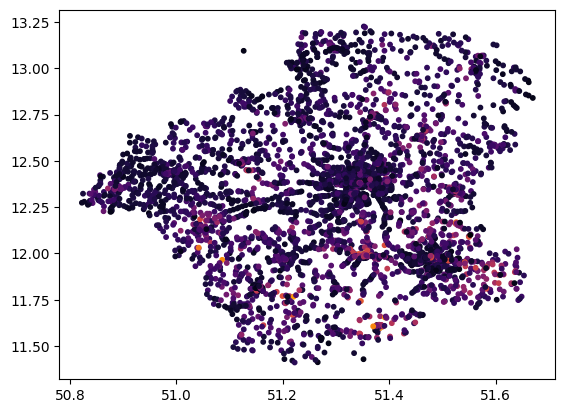

In [1]:
import matplotlib.pyplot as plt
from utils import load_stops
import json
import seaborn as sns

# load stops
stops = load_stops()
stop_number = len(stops)

# prepare dictionary so we can just look up coordinates
all_stops = {}
for i in range (stop_number + 1):
    all_stops.setdefault(i, [])

for id, _ , lat, lon in stops:
    all_stops[id] = [float(lat), float(lon)]

f = open("lvb_auswertung/neighbours_1.json")
nb = json.load(f)

x = []
y = []
w = []
for key_stop, nb_list in nb.items():
    w.append(len(nb_list))
    x1, y1 = all_stops[key_stop]
    x.append(x1)
    y.append(y1)

fig, ax = plt.subplots()

cm = plt.cm.get_cmap('inferno')

#plt.xticks([50,52])
#plt.yticks([12.2,12.6])
plot = plt.scatter(x,y,c = w, s = 10, cmap = cm, alpha = 1)
plt.show()








das ganze als heatmap

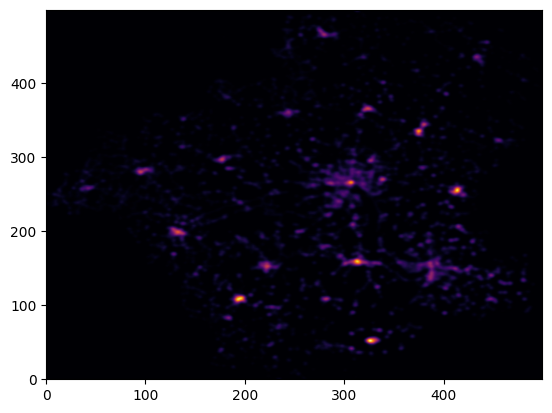

In [2]:
from scipy.interpolate import griddata
import numpy as np
from scipy.ndimage import gaussian_filter

BLUR = 2
BINS = 500 # how detailed

fig, ax = plt.subplots()
data = np.histogram2d(np.array(x), np.array(y),weights = np.array(w), bins=BINS)[0]
data = gaussian_filter(data, sigma=BLUR)
plt.pcolormesh(data.T, cmap='inferno', shading='gouraud')
#ax.set_xticks([])
#ax.set_yticks([])
fig.canvas.draw()